In [1]:
from vapory import *
from IPython.display import Image
import numpy as np
from IPython.display import *
%pylab inline
import matplotlib.pyplot as plt
import time

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
X0 = 0
F0 = [1, 0]
XF = 10
g = 10.
l = 5.

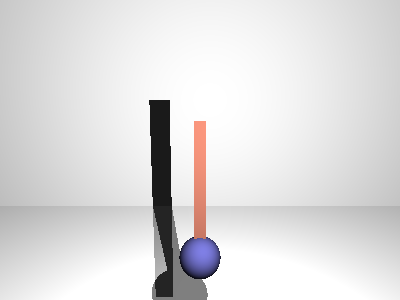

In [3]:
color = lambda col: Texture( Pigment( 'color', col))

def scene(t):
    """ Returns the scene at time 't' (in seconds) """
    x = np.sin(np.deg2rad(t))*l
    y = 1-np.cos(np.deg2rad(t))*l
    
    wall = Plane([0, 0, 1], 20, Texture(Pigment('color', [1, 1, 1])))
    ground = Plane( [0, -20, 0], 10,
                Texture( Pigment( 'color', [1, 1, 1]),
                         Finish( 'phong', 0.1,
                                 'reflection',0.4,
                                 'metallic', 0.3)))

    
    pendulum = Union(Box([-.2, l, 0] , [.2,0,0],
                        color([1,.6,.5])),
                    Sphere( [0,0,0] , .75,  color([.5, .5, .9])),
                    'rotate', [0, 0, t],
                    'translate', [x, y, 0] )
    return Scene( Camera( 'location', [0, 2, -10], 'look_at',  [0, 0, 0] ),
            [ LightSource( [1, 1, -5], 'color', [1.5,1.5,1.5] ),
              Background( "color", [1,1,1] ),
              pendulum,
              wall,
              ground])
scene(0).render('ipython', width=400, height=300)

In [4]:
from moviepy.editor import VideoClip

In [5]:
figsize(12, 12)

In [6]:
def f(t, Ys):
    y, v = Ys
    return np.array([-v*g/l, y])

In [7]:
def F(y, F0 = F0):
    return F0[0]*np.cos(y*np.power(g/l, 1/2))

In [8]:
def simple_euler(g = f, G = F, G0 = F0, Xs = np.linspace(X0, XF)):
    X0 = Xs[0]
    h = Xs[1] - X0
    N = len(Xs)
    Ys = np.zeros(Xs.shape + (2,))
    Ys[0] = G0
    for i in range(N-1):
        Ys[i+1] = Ys[i] + h*g(Xs[i], Ys[i])
    return Ys.T

In [9]:
def plot_results_for(M, with_n = [1e2]):
    _, plots = plt.subplots(len(with_n)+1, sharex=True)
    for plot, n in zip(plots[1:], with_n):
        Xs = np.linspace(X0, XF, n)
        h = round(np.log10(abs(Xs[1] - Xs[0])), 2)
        TS = F(Xs)
        S = M(Xs = Xs)[0]
        label = 'solution ' + str(h)
        plots[0].plot(Xs, S, label=label)
        plot.set_title(label)
        errs = np.log10(np.absolute(np.power(S - TS, 2)/TS))
        plot.plot(Xs[1:], (errs[1:]))
    plots[0].plot(Xs, TS, label='original')
    plots[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=6)
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.7)

In [72]:
simple_euler()[1]

array([ 0.        ,  0.20408163,  0.40816327,  0.59524518,  0.74832765,
        0.85182702,  0.89299173,  0.86320041,  0.75902411,  0.5829444 ,
        0.34363903,  0.05577519, -0.26071331, -0.5818478 , -0.88126524,
       -1.13221555, -1.30975768, -1.39298781, -1.36711693, -1.22521207,
       -0.96942826, -0.61158596, -0.17299162,  0.31654699,  0.82049556,
        1.2980762 ,  1.7073107 ,  2.00841722,  2.16730712,  2.15889862,
        1.96995641,  1.60118092,  1.06831076,  0.40206444, -0.3531707 ,
       -1.14189726, -1.90120518, -2.56539463, -3.07121631, -3.36334413,
       -3.39964386, -3.15578165, -2.62873377, -1.83881362, -0.82992356,
        0.33213715,  1.56332935,  2.76685498,  3.84015742,  4.68298465])

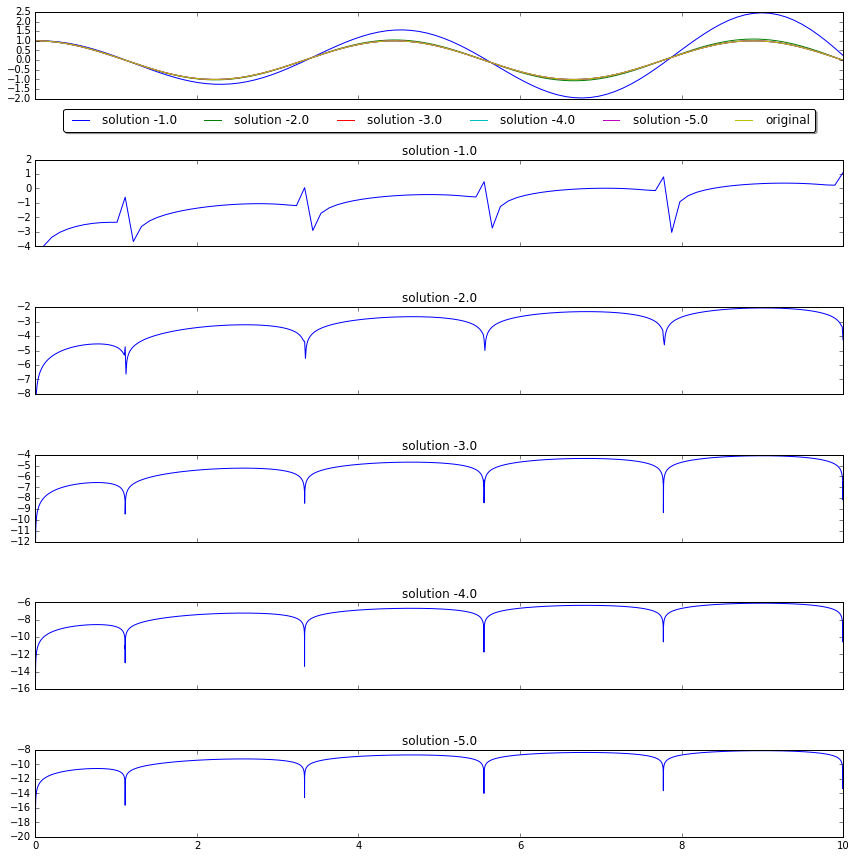

In [10]:
plot_results_for(simple_euler, with_n = [1e2, 1e3, 1e4, 1e5, 1e6])

In [11]:
def merson(g = f, G = F, G0 = F0, Xs = np.linspace(X0, XF)):
    X0 = Xs[0]
    h = Xs[1] - X0
    N = len(Xs)
    Ys = np.zeros(Xs.shape + (2,))
    Ys[0] = G0
    for i in range(N-1):
        k1 = h*g(Xs[i], Ys[i])
        k2 = h*g(Xs[i] + h/3., Ys[i] + k1/3.)
        k3 = h*g(Xs[i] + h/3., Ys[i] + (k1 + k2)/6.)
        k4 = h*g(Xs[i] + h/2., Ys[i] + (k1 + k3*3.)/8.)
        k5 = h*g(Xs[i+1], Ys[i] + (k1 - k3*3. + k4*4)/2.)
        Ys[i+1] = Ys[i] + k1/6. + k4*2./3. + k5/6.
    return Ys.T

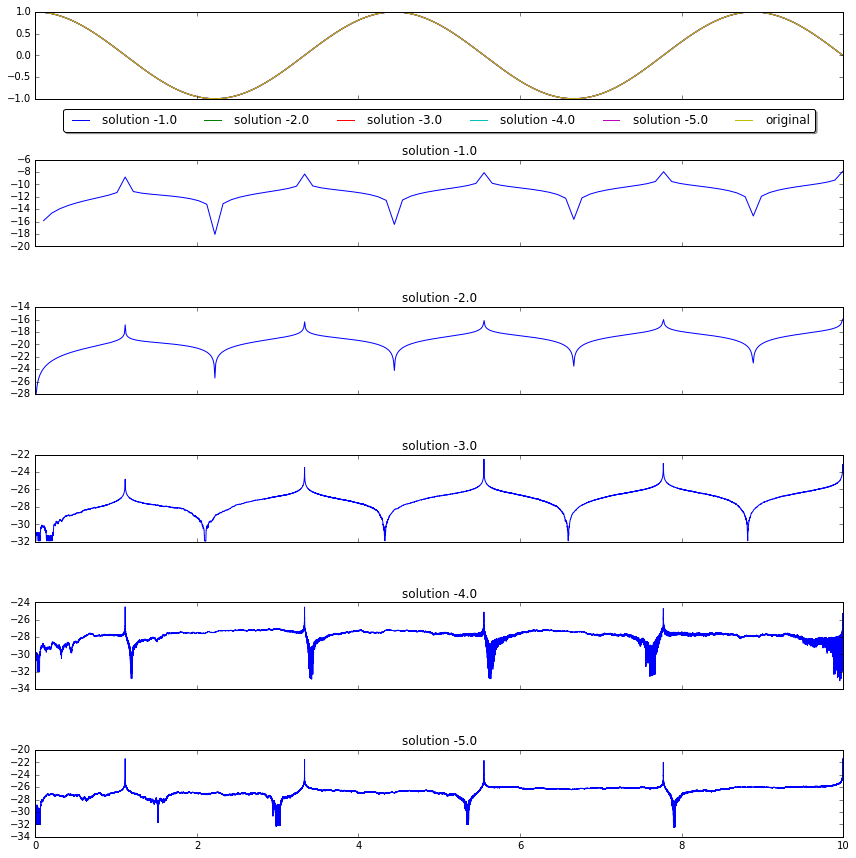

In [12]:
plot_results_for(merson, with_n = [1e2, 1e3, 1e4, 1e5, 1e6])

In [13]:
def middle_point(g = f, G = F, G0 = F0, Xs = np.linspace(X0, XF)):
    X0 = Xs[0]
    h = Xs[1] - X0
    N = len(Xs)
    Ys = np.zeros(Xs.shape + (2,))
    Ys[0] = G0
    for i in range(N-1):
        k1 = h*g(Xs[i], Ys[1])
        k2 = h*g((Xs[i] + Xs[i+1])/2., Ys[i] + k1/2.)
        Ys[i+1] = Ys[i] + k2
    return Ys.T

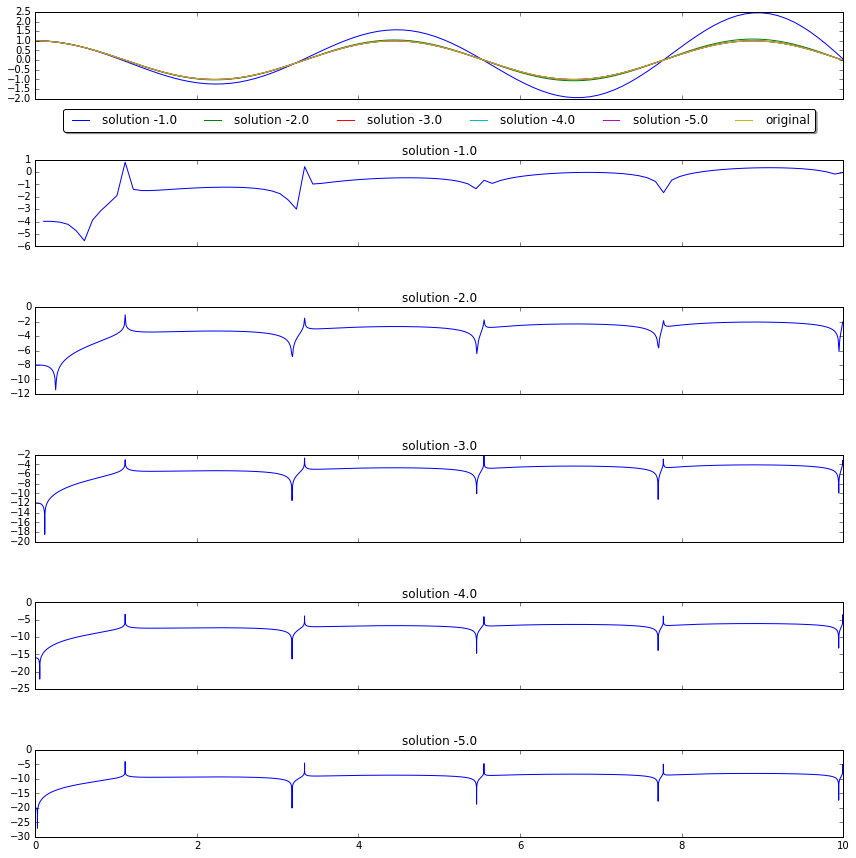

In [14]:
plot_results_for(middle_point, with_n = [1e2, 1e3, 1e4, 1e5, 1e6])

In [27]:
def z(t, Ys):
    y, v = Ys
    return np.array([-np.sin(v)*g/l, y])

In [28]:
def plot_nlresults_for(M, with_n = [1e2]):
    for n in with_n:
        Xs = np.linspace(X0, XF, n)
        h = round(np.log10(abs(Xs[1] - Xs[0])), 2)
        S = M(Xs = Xs, g = z)[0]
        label = 'solution ' + str(h)
        plt.plot(Xs, S, label=label)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=6)
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.7)

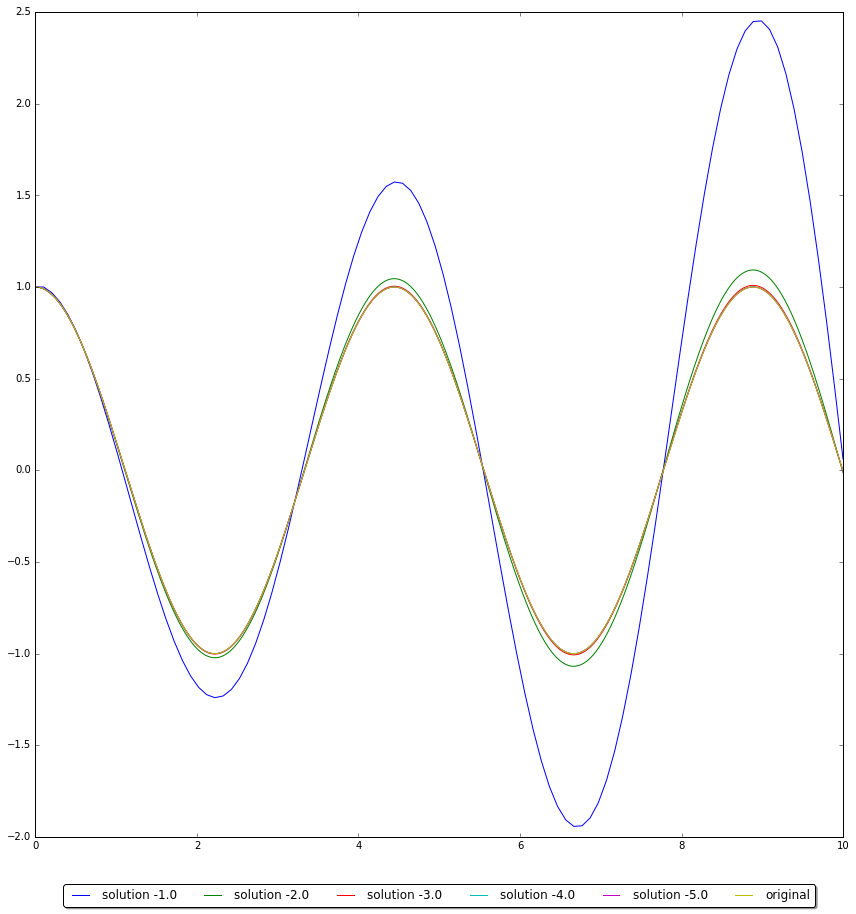

In [30]:
plot_nlresults_for(middle_point, with_n = [1e2, 1e3, 1e4, 1e5, 1e6])

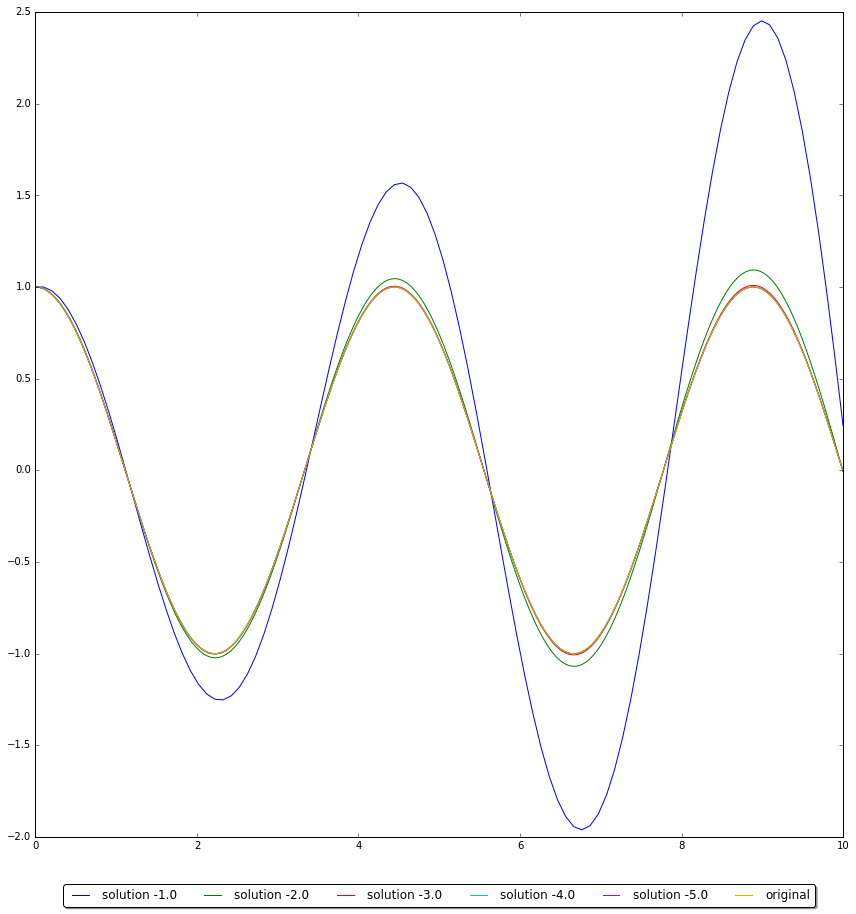

In [31]:
plot_nlresults_for(simple_euler, with_n = [1e2, 1e3, 1e4, 1e5, 1e6])

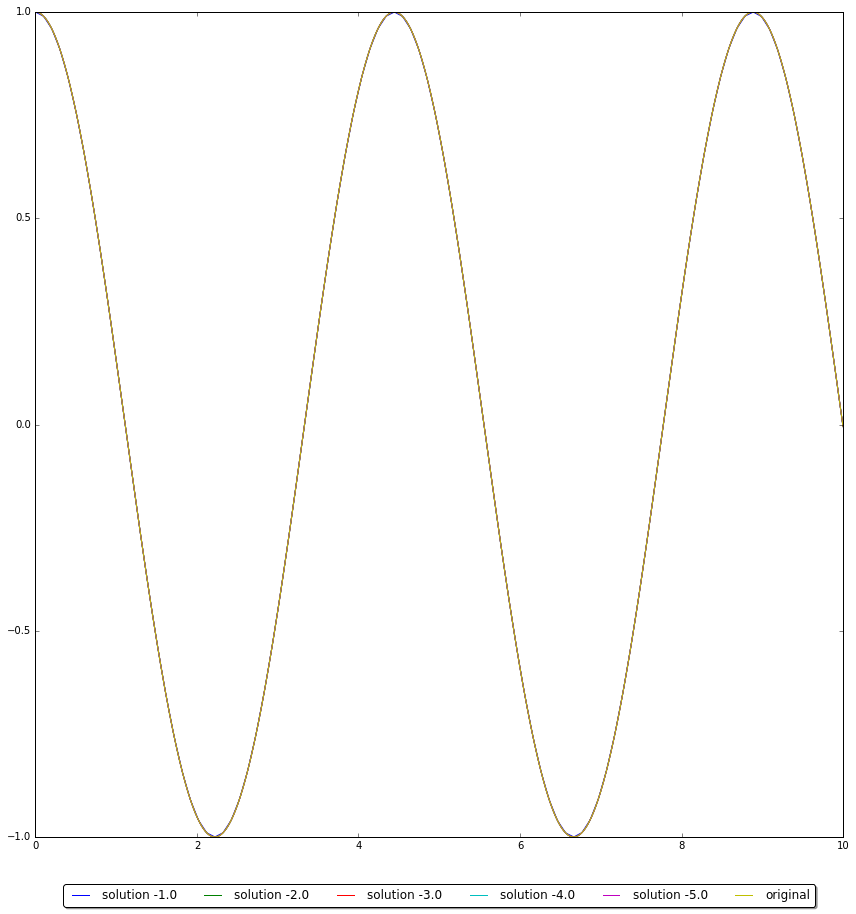

In [32]:
plot_nlresults_for(merson, with_n = [1e2, 1e3, 1e4, 1e5, 1e6])

In [20]:
Xs = np.linspace(X0, 10, 300)
S = merson(Xs = Xs, g = z, G0 = F0)[0]

In [22]:
def make_frame(S=S, alpha=1000, d=10):
    return lambda t: scene(alpha*S[int(t/d*S.size)]).render(width = 400, height = 300, antialiasing=0.1)

In [23]:
name = "anim_%d.gif" % time.time() 
VideoClip(make_frame(alpha=40, d=10), duration=10).write_gif(name, fps=30)
Image(url = name)


[MoviePy] Building file anim_1459982756.gif with imageio


In [24]:
m = 2
c = 2
def w(t, Ys):
    y, v = Ys
    p = -1*m/(l*l)
    return np.array([p*(np.sin(v)*g*m*l + c*l*y), y])

In [25]:
S1 = merson(Xs = Xs, g = w, G0 = F0)[0]

In [26]:
name = "anim_%d.gif" % time.time() 
VideoClip(make_frame(alpha=40, d=10, S=S1), duration=10).write_gif(name, fps=30)
Image(url = name)


[MoviePy] Building file anim_1459983008.gif with imageio
